In [1]:
import sys
sys.path.append('/workspace/removing-layer-norm/')
from mech_interp.load_models import *
import transformer_lens.utils as utils
import torch
device: torch.device = utils.get_device()
from fancy_einsum import einsum
from functools import partial
from typing import List, Optional, Union

import einops
import numpy as np
import plotly.express as px

import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

In [2]:
torch.set_grad_enabled(False)

def load_noLN_small():
    model_path = "/workspace/removing-layer-norm/mech_interp/models/marat_gpt2_noLN_small" 
    download_model_if_not_exists(
    repo_id="submarat/gpt2-noln-ma-aux",
    revision="main",
    local_dir=model_path
    )

    model = GPT2LMHeadModel.from_pretrained(model_path)
    for block in model.transformer.h:
        block.ln_1.weight.data = block.ln_1.weight.data / 1e6
        block.ln_1.eps = 1e-5
        block.ln_2.weight.data = block.ln_2.weight.data / 1e6
        block.ln_2.eps = 1e-5
    model.transformer.ln_f.weight.data = model.transformer.ln_f.weight.data / 1e6
    model.transformer.ln_f.eps = 1e-5
    
    # Properly replace LayerNorms by Identities
    class HookedTransformerNoLN(HookedTransformer):
        def removeLN(self):
            for i in range(len(self.blocks)):
                self.blocks[i].ln1 = t.nn.Identity()
                self.blocks[i].ln2 = t.nn.Identity()
            self.ln_final = t.nn.Identity()
    
    hooked_model = HookedTransformerNoLN.from_pretrained("gpt2", hf_model=model, fold_ln=True, center_unembed=True)

    hooked_model.removeLN()
    hooked_model.cfg.normalization_type = None
    return hooked_model

def load_baseline_small():
    hooked_model = HookedTransformer.from_pretrained("gpt2-small", fold_ln=True, center_unembed=True)
    return hooked_model

noLN = load_noLN_small()
baseline = load_baseline_small()


Model already exists at /workspace/removing-layer-norm/mech_interp/models/marat_gpt2_noLN_small. Skipping download.


Loaded pretrained model gpt2 into HookedTransformer
Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
prompt_format = [
    "When John and Mary went to the shops,{} gave the bag to",
    "When Tom and James went to the park,{} gave the ball to",
    "When Dan and Sid went to the shops,{} gave an apple to",
    "After Martin and Amy went to the park,{} gave a drink to",
]
names = [
    (" Mary", " John"),
    (" Tom", " James"),
    (" Dan", " Sid"),
    (" Martin", " Amy"),
]
# List of prompts
prompts = []
# List of answers, in the format (correct, incorrect)
answers = []
# List of the token (ie an integer) corresponding to each answer, in the format (correct_token, incorrect_token)
answer_tokens = []
for i in range(len(prompt_format)):
    for j in range(2):
        answers.append((names[i][j], names[i][1 - j]))
        answer_tokens.append(
            (
                baseline.to_single_token(answers[-1][0]),
                baseline.to_single_token(answers[-1][1]),
            )
        )
        # Insert the *incorrect* answer to the prompt, making the correct answer the indirect object.
        prompts.append(prompt_format[i].format(answers[-1][1]))
answer_tokens = torch.tensor(answer_tokens).to(device)

correct_tokens = answer_tokens[:, 0]
for prompt, correct_token in zip(prompts, correct_tokens):
    print(prompt)
    print(correct_token.item(), baseline.to_string(correct_token.item()))
    print()

When John and Mary went to the shops, John gave the bag to
5335  Mary

When John and Mary went to the shops, Mary gave the bag to
1757  John

When Tom and James went to the park, James gave the ball to
4186  Tom

When Tom and James went to the park, Tom gave the ball to
3700  James

When Dan and Sid went to the shops, Sid gave an apple to
6035  Dan

When Dan and Sid went to the shops, Dan gave an apple to
15686  Sid

After Martin and Amy went to the park, Amy gave a drink to
5780  Martin

After Martin and Amy went to the park, Martin gave a drink to
14235  Amy



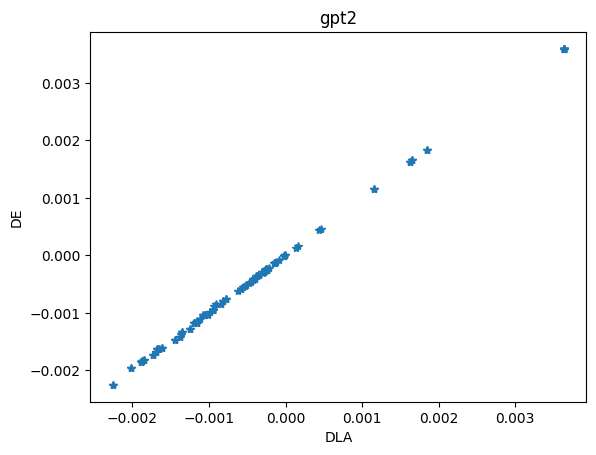

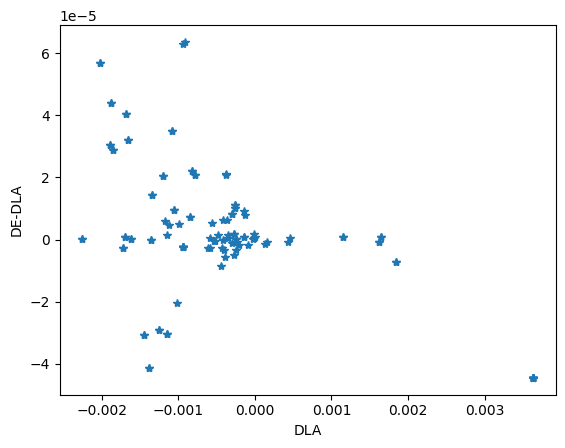

In [4]:
logits, cache = baseline.run_with_cache(prompts)

residual_stream = cache['blocks.11.hook_resid_post']
neuron_idx = 4
neuron_contributions = cache.get_neuron_results(layer=5)[:,:, neuron_idx, :]
ablated_residual = residual_stream-neuron_contributions

DE = baseline.unembed(baseline.ln_final(residual_stream)) - baseline.unembed(baseline.ln_final(ablated_residual)) 
DLA = baseline.unembed(cache.apply_ln_to_stack(neuron_contributions, -1)) - baseline.b_U
DE = DE.detach().cpu()
DLA = DLA.detach().cpu()

import matplotlib.pyplot as plt
plt.plot(DLA[:, :,0].flatten(), DE[:, :,0].flatten(), '*')
plt.xlabel('DLA')
plt.ylabel('DE')
plt.title('gpt2')
plt.show()
import matplotlib.pyplot as plt
plt.plot(DLA[:, :,0].flatten(), DE[:,:,0].flatten()-DLA[:,:,0].flatten(), '*')
plt.xlabel('DLA')
plt.ylabel('DE-DLA')
plt.show()

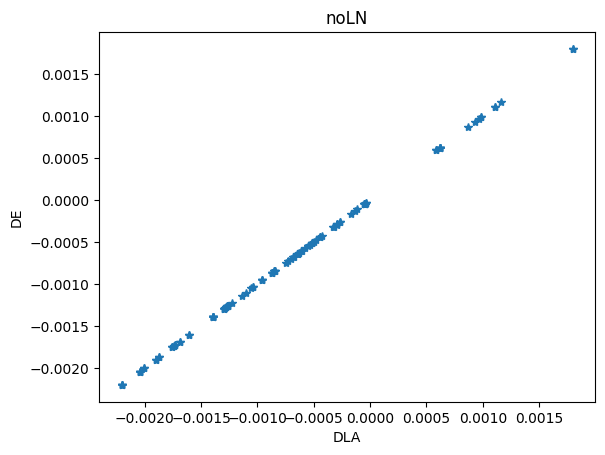

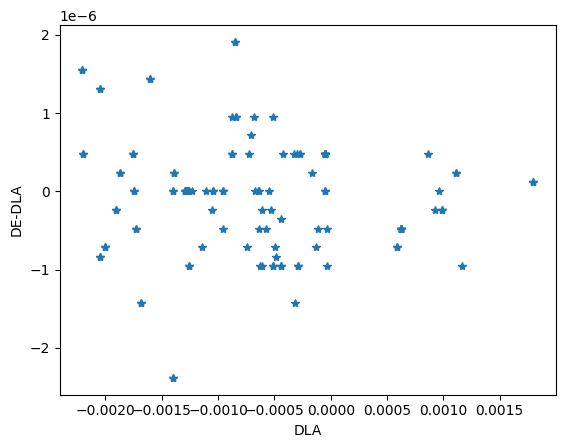

In [5]:
logits, cache = noLN.run_with_cache(prompts)
residual_stream = cache['blocks.11.hook_resid_post']
neuron_idx = 4

neuron_contributions = cache.get_neuron_results(layer=5)[:,:, neuron_idx, :]
ablated_residual = residual_stream-neuron_contributions

DE = noLN.unembed(noLN.ln_final(residual_stream)) - noLN.unembed(noLN.ln_final(ablated_residual))
DLA = noLN.unembed(cache.apply_ln_to_stack(neuron_contributions, -1)) - noLN.b_U
DE = DE.detach().cpu()
DLA = DLA.detach().cpu()

plt.title('noLN')
import matplotlib.pyplot as plt
plt.plot(DLA[:, :,0].flatten(), DE[:, :,0].flatten(), '*')
plt.xlabel('DLA')
plt.ylabel('DE')
plt.show()
import matplotlib.pyplot as plt
plt.plot(DLA[:, :,0].flatten(), DE[:,:,0].flatten()-DLA[:,:,0].flatten(), '*')
plt.xlabel('DLA')
plt.ylabel('DE-DLA')
plt.show()

Tried to stack head results when they weren't cached. Computing head results now


Tried to stack head results when they weren't cached. Computing head results now


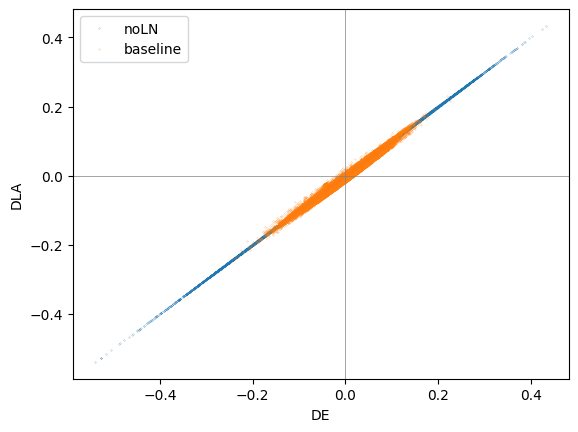

In [6]:
import matplotlib.pyplot as plt

def DE_vs_DLA_all_heads(prompts, model):
    with torch.no_grad():
        _, cache = model.run_with_cache(prompts)
        residual_stream = cache['blocks.11.hook_resid_post']
        head_results = cache.stack_head_results(layer=-1)
        residual_stream = residual_stream.unsqueeze(0).repeat((len(head_results),1,1,1))
        ablated_residual = residual_stream-head_results

        DE = einsum('d_model d_vocab, ... d_model -> ... d_vocab', model.W_U, model.ln_final(residual_stream)) - einsum('d_model d_vocab, ... d_model -> ... d_vocab', model.W_U, model.ln_final(ablated_residual))
        ln_head_results = torch.stack([cache.apply_ln_to_stack(head_result, -1) for head_result in head_results])
        DLA = einsum('d_model d_vocab, ... d_model -> ... d_vocab', model.W_U, ln_head_results)
        
        DE = DE.detach().cpu()
        DLA = DLA.detach().cpu()
        return DE, DLA

DE_noLN, DLA_noLN = DE_vs_DLA_all_heads(prompts, noLN)
DE_baseline, DLA_baseline =  DE_vs_DLA_all_heads(prompts, baseline)

plt.plot(DE_noLN.reshape(-1, 50257)[0], DLA_noLN.reshape(-1, 50257)[0], '.',markersize=0.3, label='noLN')
plt.plot(DE_baseline.reshape(-1, 50257)[0], DLA_baseline.reshape(-1, 50257)[0], '.', markersize=0.3, label='baseline')
plt.axvline(0, c='grey', linewidth=0.5)
plt.axhline(0, c='grey', linewidth=0.5)
plt.xlabel('DE')
plt.ylabel('DLA')
plt.legend()
plt.show()

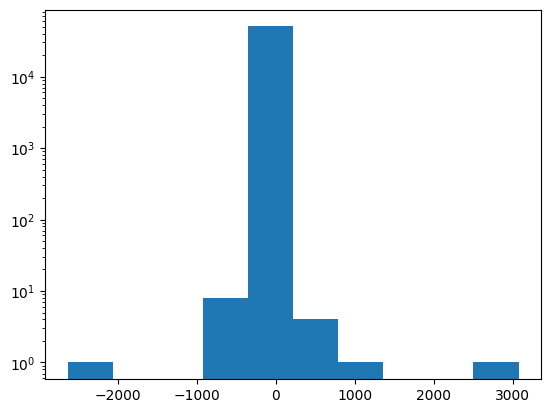

In [7]:
plt.hist(((DE_baseline.reshape(-1, 50257)[0]-DLA_baseline.reshape(-1, 50257)[0]))/DLA_baseline.reshape(-1, 50257)[0])
plt.yscale('log')
plt.xlabel('')
plt.show()

In [8]:

torch.corrcoef(torch.stack([DE_baseline.reshape(-1, 50257)[0], DLA_baseline.reshape(-1, 50257)[0]]))

tensor([[1.0000, 0.9904],
        [0.9904, 1.0000]])

In [9]:
def get_logit_diff_from_stack(logits_stack, answer_tokens):
    dims = logits_stack.shape
    correct = answer_tokens[:,0].view(1, len(answer_tokens), 1, 1).expand(dims[0], -1, dims[2], 1).cpu()
    wrong = answer_tokens[:,1].view(1, len(answer_tokens), 1, 1).expand(dims[0], -1, dims[2], 1).cpu()
    diff = torch.gather(logits_stack, dim=3, index=correct) - torch.gather(logits_stack, dim=3, index=wrong)
    return diff.squeeze()

with torch.no_grad():# Print shapes for debugging

    # Fixed: Use the same tensor for both gather operations in each subtraction
    DE_noLN_ioi = get_logit_diff_from_stack(DE_noLN, answer_tokens)[:, :, -1]
    DLA_noLN_ioi= get_logit_diff_from_stack(DLA_noLN, answer_tokens)[:, :, -1]
    DE_baseline_ioi = get_logit_diff_from_stack(DE_baseline, answer_tokens)[:, :, -1]
    DLA_baseline_ioi= get_logit_diff_from_stack(DLA_baseline, answer_tokens)[:, :, -1]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


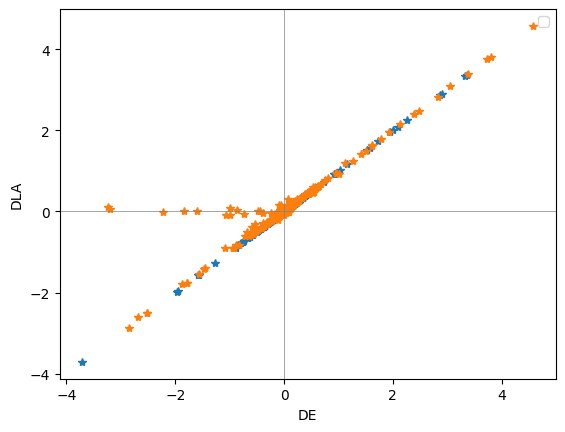

In [10]:
plt.plot(DE_noLN_ioi.flatten(), DLA_noLN_ioi.flatten(), '*')
plt.plot(DE_baseline_ioi.flatten(), DLA_baseline_ioi.flatten(), '*')
plt.axvline(0, c='grey', linewidth=0.5)
plt.axhline(0, c='grey', linewidth=0.5)
plt.xlabel('DE')
plt.ylabel('DLA')
plt.legend()
plt.show()

In [ ]:
logits, cache = noLN.run_with_cache(prompts)
residual_stream = cache['blocks.11.hook_resid_post']
head_results = cache.stack_head_results(layer=-1)
residual_stream = residual_stream.unsqueeze(0).repeat((len(head_results),1,1,1))
ablated_residual = residual_stream-head_results

DE = noLN.W_U(noLN.ln_final(residual_stream)) - noLN.W_U(noLN.ln_final(ablated_residual))
DLA = noLN.W_U(torch.stack([cache.apply_ln_to_stack(head_result, -1) for head_result in head_results]))
DE = DE.detach().cpu()
DLA = DLA.detach().cpu()

import matplotlib.pyplot as plt
plt.title('noLN')
plt.plot(DLA[:, :, :,0].flatten(), DE[:, :,:,0].flatten(), '*')
plt.xlabel('DLA')
plt.ylabel('DE')
plt.show()
import matplotlib.pyplot as plt
plt.plot(DLA[:, :,:,0].flatten(), DE[:,:,:,0].flatten()-DLA[:,:,:,0].flatten(), '*')
plt.xlabel('DLA')
plt.ylabel('DE-DLA')
plt.show()